In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import json

In [76]:
OBJ_ID             = "obj04"
OBJ_CONFIG         = json.load(open(f"../config/{OBJ_ID}.json"))
OBJ_VIDEO_PATH     = f"../data/{OBJ_ID}.mp4"
OBJ_MASK_PATH      = f"../processed/{OBJ_ID}/masks.npy"

CHROMA_LOWER_BOUND = [100, 60, 0]
CHROMA_UPPER_BOUND = [140, 255, 255]

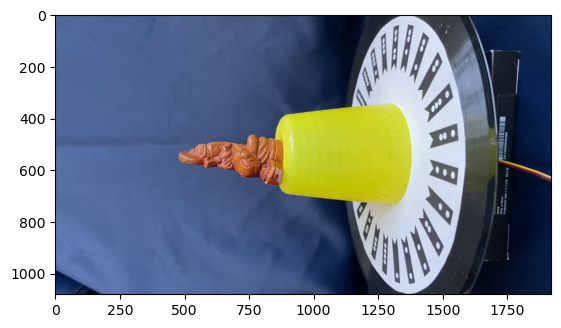

In [77]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)
    
assert cap.isOpened(), "Unable to acquire video stream"
    
ret, bgr_frame = cap.read()

cap.release()

rgb_frame = cv.cvtColor(bgr_frame, cv.COLOR_BGR2RGB)

plt.imshow(rgb_frame)

In [78]:
def chroma_segment (fr):
    # 1. 
    hsv  = cv.cvtColor(fr, cv.COLOR_BGR2HSV)
    masked = 255 - cv.inRange(hsv, np.array(CHROMA_LOWER_BOUND), np.array(CHROMA_UPPER_BOUND))
    
    # 2.
    retr_mode  = cv.RETR_EXTERNAL if OBJ_CONFIG["watershed"]["fill_holes"] else cv.RETR_CCOMP
    cnt_obj, _ = cv.findContours(masked[200:1000, 500:1000], retr_mode, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(masked, cnt_obj, -1, 255, -1, offset = (500, 200))
    
    # 3.
    cnt_mark,  _ = cv.findContours(masked[0:1080, 1100:1920], cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(masked, cnt_mark, -1, 255, -1, offset = (1100, 0))
    
    # 4.
    #masked[0:1080, 1320:1920] = 255
    
    #
    return masked

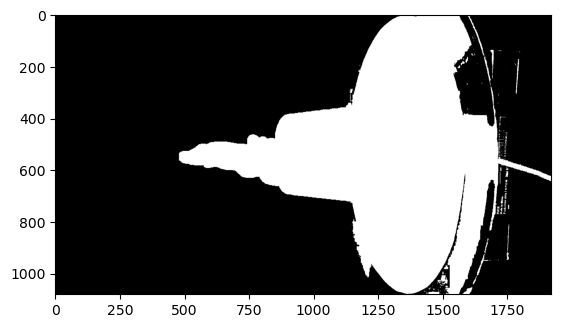

In [79]:
c_frame = bgr_frame.copy()
seg_frame = chroma_segment(c_frame)

plt.imshow(seg_frame, cmap = 'gray')

In [80]:
def threshold_with_distance (seg):

    dist = cv.distanceTransform(seg, cv.DIST_L2, 3)
    
    cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
    
    _, thresholded = cv.threshold(dist, 0.03, 1.0, cv.THRESH_BINARY)
    
    return dist, thresholded

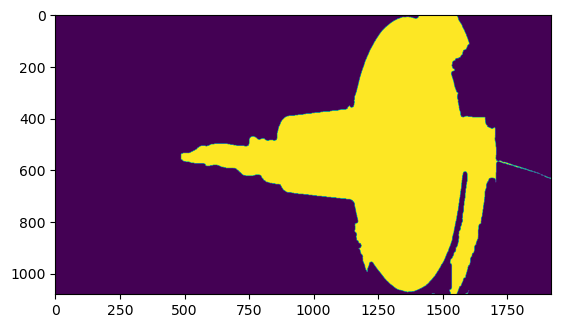

In [81]:
dist, th_frame = threshold_with_distance(seg_frame)
th_8_frame = th_frame.astype('uint8')

plt.imshow(th_8_frame)

In [82]:
# With cv.RETR_CCOMP retrieval mode we divide contours in two groups: external contours and hole contours
def get_markers (th_8_fr, dist):
    contours, h = cv.findContours(th_8_fr, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    
    markers = np.zeros(dist.shape, dtype=np.int32)
    cv.circle(markers, (20,20), 4, (255, 255, 255), -1)

    for i in range(len(contours)):
        is_hole = h[0][i][3] != -1
        if (is_hole):
            M = cv.moments(contours[i])
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv.circle(markers, (cx,cy), 4, (255, 255, 255), -1)
        else:
            cv.drawContours(markers, contours, i, 1, thickness = cv.FILLED, hierarchy = h, maxLevel = 1)
    
    return markers

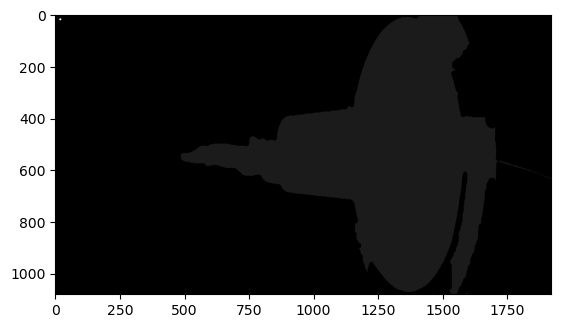

In [83]:
markers = get_markers(th_8_frame, dist)
plt.imshow((markers * 25).astype('uint8'), cmap = 'gray')

In [84]:
masks = []

cap = cv.VideoCapture(OBJ_VIDEO_PATH)

while (cap.isOpened()):
    ret, frame = cap.read()
    
    if not ret:
        break
    
    segmented = chroma_segment(frame)
    
    dist, thresholded = threshold_with_distance(segmented)
    
    thresholded_u8 = thresholded.astype('uint8')
    
    markers = get_markers(thresholded_u8, dist)
    
    cv.watershed(frame, markers)
    
    mask = cv.bitwise_not(markers.astype('uint8'))
    
    bin_mask = (mask / 254).astype('uint8')
    
    masks.append(bin_mask)
    
    segmented2 = cv.bitwise_and(frame, frame, mask = mask)
    
    cv.imshow('frame',segmented2)
    
    if cv.waitKey(25) & 0xFF == ord('q'):
        break
     
cap.release()
cv.destroyAllWindows()

In [115]:
np.save(OBJ_MASK_PATH, np.array(masks))

NameError: name 'STORE_PATH' is not defined